<a href="https://colab.research.google.com/github/Neha-kumari31/DS-Unit-2-Regression-Classification/blob/master/module2/Kaggle_Challenge_1_(Module_1)_IN_LESSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Kaggle Challenge, Module 1


#### Objectives
- clean outliers, **impute** missing values
- use scikit-learn **pipelines**
- use scikit-learn for **decision trees**
- get and interpret **feature importances** of a tree-based model
- understand why decision trees are useful to model **non-linear, non-monotonic** relationships and **feature interactions**


#### Links

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module1')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 85, done.
remote: Total 85 (delta 0), reused 0 (delta 0), pack-reused 85
Unpacking objects: 100% (85/85), done.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 112kB 9.0MB/s 
     |████████████████████████████████| 133kB 37.1MB/s 
     |████████████████████████████████| 57.7MB 1.2MB/s 
     |████████████████████████████████| 245kB 46.0MB/s 
     |████████████████████████████████| 614kB 45.3MB/s 
     |████████████████████████████████| 225kB 37.9MB/s 
     |████████████████████████████████| 768kB 47.3MB/s 
     |████████████████████████████████| 194kB 56.2MB/s 
     |████████████████████████████████| 51kB 11.4MB/s 
     |████████████████████████████████| 737kB 20.0MB/s 
     |███████████████████████████████

In [0]:
# Use this function later

%matplotlib inline
import itertools
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns

def pred_heatmap(model, X, features, class_index=-1, title='', num=100):
    """
    Visualize predicted probabilities, for classifier fit on 2 numeric features
    
    Parameters
    ----------
    model : scikit-learn classifier, already fit
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 numeric features
    class_index : integer, index of class label
    title : string, title of plot
    num : int, number of grid points for each feature
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(max2, min2, num)
    combos = list(itertools.product(x1, x2))
    y_pred_proba = model.predict_proba(combos)[:, class_index]
    pred_grid = y_pred_proba.reshape(num, num).T
    table = pd.DataFrame(pred_grid, columns=x1, index=x2)
    plot_every_n_ticks = int(floor(num/4))
    sns.heatmap(table, xticklabels=plot_every_n_ticks, yticklabels=plot_every_n_ticks)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(title)
    plt.show()

# Clean outliers, impute missing values

First, load & split data.

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

Some of the locations are at ["Null Island"](https://en.wikipedia.org/wiki/Null_Island) instead of Tanzania.

In [0]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

The latitude is approximately zero, but not exactly:

In [0]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

#### Define a function to wrangle train, validate, and test sets in the same way.

Fix the location, and do more data cleaning and feature engineering.

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

Now the locations look better.

In [0]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

By the way, you can also make maps wiith Plotly Express. For example:

In [0]:
# https://plot.ly/python/mapbox-layers/#base-maps-in-layoutmapboxstyle
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

#### Select features

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Use scikit-learn pipelines

We can combine steps with pipelines: Encode, Impute, Scale, Fit, Predict!

[The Scikit-Learn User Guide explains why pipelines are useful](https://scikit-learn.org/stable/modules/compose.html), and demonstrates how to use them.

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:
> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

#### For comparison, here's preprocessing + Logistic Regression _without_ using a pipeline

Here's the documentation for each step in the process:

- https://contrib.scikit-learn.org/categorical-encoding/onehot.html
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

Validation Accuracy 0.7308080808080808


#### Pipelines can help you write more concise code with fewer errors!

Let's rewrite the code cell above, but with a pipeline.

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html

In [0]:
# TODO

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline (
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

pipeline.fit(X_train, y_train)

print ('Validation Accuracy', pipeline.score(X_val, y_val))

y_pred = pipeline.predict(X_test)

Validation Accuracy 0.7308080808080808


#### Get and plot coefficients

This is slightly harder when using pipelines.

The pipeline doesn't have a `.coef_` attribute. But the model inside the pipeline does. 

So, here's [how to access steps inside a pipeline](https://scikit-learn.org/stable/modules/compose.html#accessing-steps):

> Pipeline’s `named_steps` attribute allows accessing steps by name

In [0]:
pipeline.named_steps

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=-1, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'onehotencoder': OneHotEncoder(cols=['basin', 'region', 'public_meeting', 'recorded_by',
                     'scheme_management', 'permit', 'extraction_type',
                     'extraction_type_group', 'extraction_type_class',
                     'management', 'management_group', 'payment', 'payment_type',
                     'water_quality', 'quality_group', 'quantity', 'source',
                     'source_type', 'source_class', 'waterpoint_type',
                     'waterpoint_type_group'],
               drop_invariant=False, handle_missing='value',
               handle_unknown='value', return_df=True, use_cat_names=True,
   

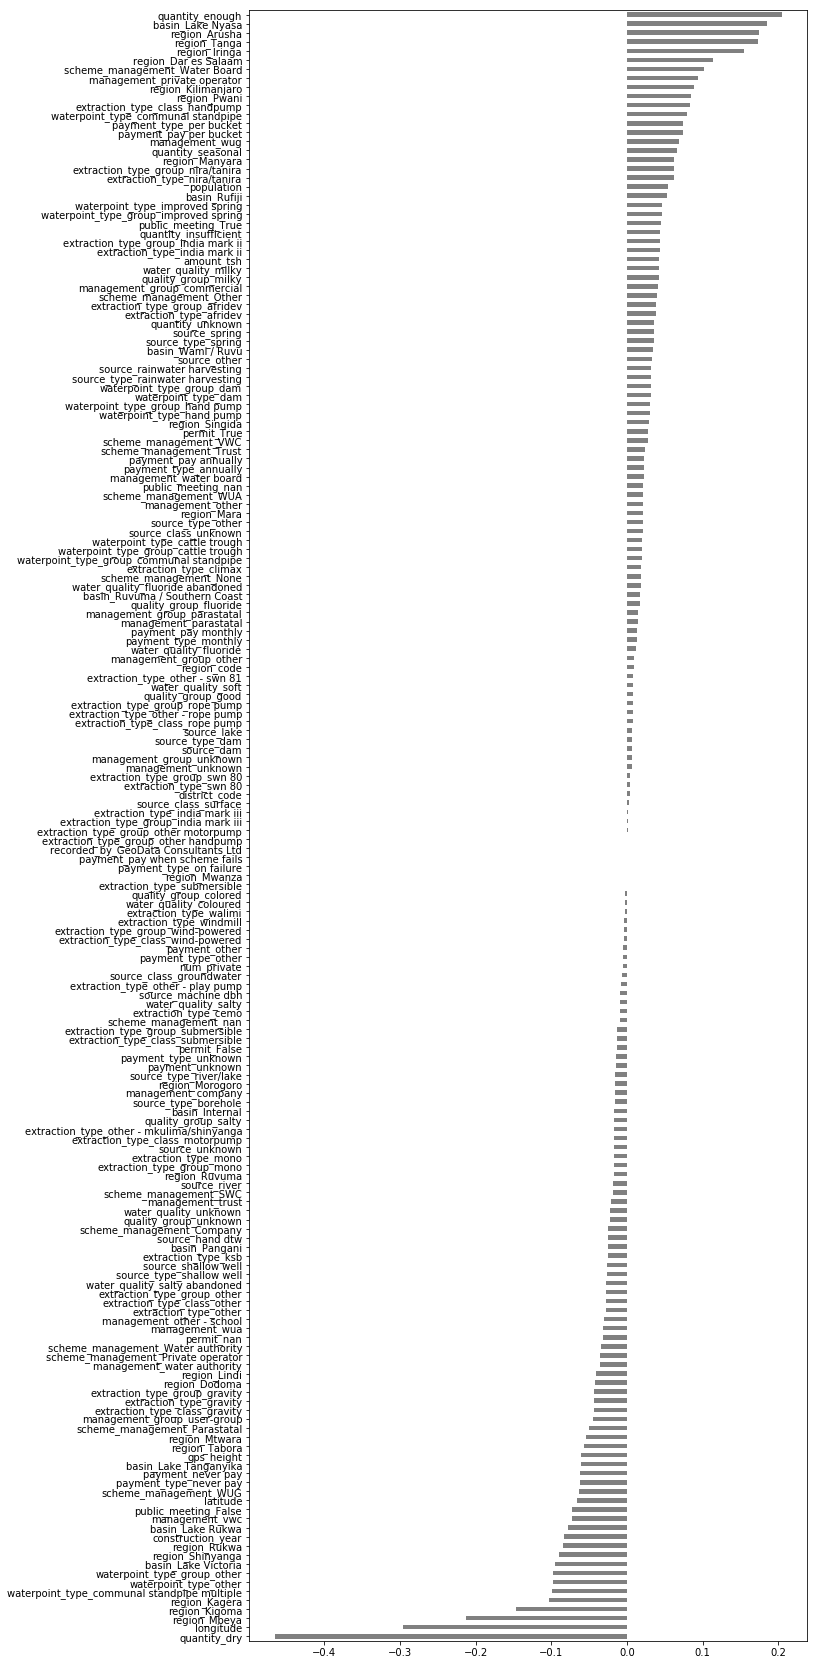

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

# Use scikit-learn for decision trees

In [0]:
# Run baseline logistic regression as a benchmark.

train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

lr = make_pipeline(
    SimpleImputer(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

lr.fit(train_location, y_train)
print ('Training Accuracy', lr.score(train_location, y_train))
print ('Validation Accuracy', lr.score(val_location, y_val))


Training Accuracy 0.5430765993265994
Validation Accuracy 0.5430976430976431


https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

We will start with default parameters, including:
- `max_depth=None`
- `min_samples_leaf=1`

In [0]:
# TODO
# What does the high training score imply?

from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

dt.fit(train_location, y_train)
print ('Training Accuracy', dt.score(train_location, y_train))
print ('Validation Accuracy', dt.score(val_location, y_val))



Training Accuracy 0.984196127946128
Validation Accuracy 0.6301346801346801


### Reduce complexity of the decision tree

We can use the `min_samples_leaf` parameter to reduce model complexity.

It's explained in [scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Also in [A Visual Introduction to Machine Learning, Part 2](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/):

> Models can be adjusted to change the way they fit the data. These 'settings' are called [hyper]parameters. An example of a decision-tree [hyper]parameter is the _minimum node size_, which regulates the creation of new splits. A node will not split if the number of data points it contains is below the minimum node size.

In [0]:
# TODO


from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(min_samples_leaf=25, random_state=42)
)

dt.fit(train_location, y_train)
print ('Training Accuracy', dt.score(train_location, y_train))
print ('Validation Accuracy', dt.score(val_location, y_val))

leaf_range = range(1,5)

for i in leaf_range:
  dt = make_pipeline(
      SimpleImputer(),
      DecisionTreeClassifier(min_samples_leaf=i, random_state=42)
  )

  dt.fit(train_location, y_train)
  print ('\n\nResults for min_samples_leaf', i,)
  print ('Training Accuracy', dt.score(train_location, y_train))
  print ('Validation Accuracy', dt.score(val_location, y_val))



Training Accuracy 0.7018939393939394
Validation Accuracy 0.6501683501683502


Results for min_samples_leaf 1
Training Accuracy 0.984196127946128
Validation Accuracy 0.6301346801346801


Results for min_samples_leaf 2
Training Accuracy 0.888510101010101
Validation Accuracy 0.6338383838383839


Results for min_samples_leaf 3
Training Accuracy 0.8568181818181818
Validation Accuracy 0.6398989898989899


Results for min_samples_leaf 4
Training Accuracy 0.8256523569023569
Validation Accuracy 0.6416666666666667


### Plot the decision tree

In [0]:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

KeyError: ignored

In [0]:
# Increase "minimum node size" / min_samples_leaf, to reduce model complexity.
# This happens to improves validation accuracy here.
# TODO



from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=25, random_state=42)
)

dt.fit(train_location, y_train)
print ('Training Accuracy', dt.score(train_location, y_train))
print ('Validation Accuracy', dt.score(val_location, y_val))



Training Accuracy 0.9527777777777777
Validation Accuracy 0.6345117845117845


In [0]:
# Or similarly, we can decrease the depth of the tree
# TODO

In [0]:
# AttributeError: 'DecisionTreeClassifier' object has no attribute 'coef_'
# model.coef_

# Get and interpret feature importances of a tree-based model

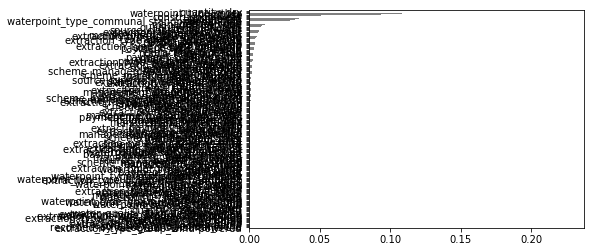

In [0]:
# TODO 
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=15, random_state=42)

)
pipeline.fit(X_train, y_train)

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_train).columns 
importances = pd.Series(model.feature_importances_, encoded_columns)
importances.sort_values().plot.barh(color='grey')

In [0]:
importances.sort_values()

extraction_type_group_wind-powered             0.000000
recorded_by_GeoData Consultants Ltd            0.000000
scheme_management_None                         0.000000
extraction_type_india mark iii                 0.000000
extraction_type_other - play pump              0.000000
extraction_type_other - rope pump              0.000000
extraction_type_climax                         0.000000
extraction_type_cemo                           0.000000
extraction_type_windmill                       0.000000
extraction_type_other - mkulima/shinyanga      0.000000
extraction_type_group_other motorpump          0.000000
waterpoint_type_group_cattle trough            0.000000
extraction_type_class_wind-powered             0.000000
water_quality_fluoride abandoned               0.000000
quality_group_milky                            0.000000
quality_group_colored                          0.000000
source_dam                                     0.000000
source_other                                   0

# Understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions

#### What does _(non)monotonic_ mean?!?!
- See Figures 1-3 in Wikipedia's article, [Monotonic function](https://en.wikipedia.org/wiki/Monotonic_function)
- See [World Population Growth, 1700-2010](https://ourworldindata.org/world-population-growth-past-future). World Population is non-linear and monotonic. Annual growth rate is non-linear and non-monotonic.
- See [Accidents per Mile Driven, by Driver Age](http://howwedrive.com/2009/02/20/whats-the-real-risk-of-older-drivers/). This is non-linear and non-monotonic.

#### What does _feature interactions_ mean?!?!
- See the explanation in [_Interpretable Machine Learning_, Chapter 5.4.1, Feature Interaction](https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction).
- See the exploration in this notebook, under the heading ***Interlude #2: Simple housing***

## Example 1: Predict which waterpumps are functional, just based on location
(2 features, non-linear, feature interactions, classification)

### Compare a Logistic Regression with 2 features, longitude & latitude ...

In [0]:
train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

In [0]:
# With just long & lat, a Logistic Regression can't beat the majority classifier baseline

lr = make_pipeline(
    SimpleImputer(),
    LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
)

lr.fit(train_location, y_train)
print('Logistic Regression:')
print('Train Accuracy', lr.score(train_location, y_train))
print('Validation Accuracy', lr.score(val_location, y_val))

Logistic Regression:
Train Accuracy 0.5430765993265994
Validation Accuracy 0.5430976430976431


### ... versus a Decision Tree Classifier with 2 features, longitude & latitude

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

We will start with default parameters, including:
- `max_depth=None`
- `min_samples_leaf=1`

In [0]:
# With the same 2 features, the Decision Tree's validation accuracy is 
# almost 10 percentage points better

from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=16, random_state=42)
)

dt.fit(train_location, y_train)
print('Logistic Regression:')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

### Visualize the logistic regression predictions

In [0]:
pred_heatmap(lr, train_location, features=['longitude', 'latitude'], 
             class_index=0, title='Logstic Regression, predicted probability, "functional"')

In [0]:
pd.Series(lr.named_steps['logisticregression'].coef_[0], 
          train_location.columns)

### Visualize the decision tree predictions

In [0]:
pred_heatmap(dt, train_location, features=['longitude', 'latitude'], 
             class_index=0, title='Logstic Regression, predicted probability, "functional"')

NameError: ignored

### How does a tree grow? Branch by branch!

In [0]:
from IPython.display import display, HTML
import graphviz
from sklearn.tree import export_graphviz

for max_depth in [1,2,3]:
    
    # Fit decision tree
    dt = make_pipeline(
        SimpleImputer(), 
        DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    )
    dt.fit(train_location, y_train)
    
    # Display depth & scores
    display(HTML(f'Max Depth {max_depth}'))
    display(HTML(f'Train Accuracy {dt.score(train_location, y_train):.2f}'))
    display(HTML(f'Validation Accuracy {dt.score(val_location, y_val):.2f}'))
    
    # Plot heatmap of predicted probabilities
    pred_heatmap(dt, train_location, features=['longitude', 'latitude'], 
                 class_index=0, title='Predicted probability, "functional"')
    
    # Plot tree
    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
    dot_data = export_graphviz(dt.named_steps['decisiontreeclassifier'], 
                               out_file=None, 
                               max_depth=3, 
                               feature_names=train_location.columns,
                               class_names=dt.classes_, 
                               impurity=False, 
                               filled=True, 
                               proportion=True, 
                               rounded=True)   
    display(graphviz.Source(dot_data))

NameError: ignored

In [0]:
for max_depth in range(4,21):
    
    # Fit decision tree
    dt = make_pipeline(
        SimpleImputer(), 
        DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    )
    dt.fit(train_location, y_train)
    
    # Display depth & scores
    display(HTML(f'Max Depth {max_depth}'))
    display(HTML(f'Train Accuracy {dt.score(train_location, y_train):.2f}'))
    display(HTML(f'Validation Accuracy {dt.score(val_location, y_val):.2f}'))
    
    # Plot heatmap of predicted probabilities
    pred_heatmap(dt, train_location, features=['longitude', 'latitude'], 
                 class_index=0, title='Predicted probability, "functional"')

## Example 2: predicting golf putts
(1 feature, non-linear, regression)

https://statmodeling.stat.columbia.edu/2008/12/04/the_golf_puttin/

In [0]:
columns = ['distance', 'tries', 'successes']
data = [[2, 1443, 1346],
        [3, 694, 577],
        [4, 455, 337],
        [5, 353, 208],
        [6, 272, 149],
        [7, 256, 136],
        [8, 240, 111],
        [9, 217, 69],
        [10, 200, 67],
        [11, 237, 75],
        [12, 202, 52],
        [13, 192, 46],
        [14, 174, 54],
        [15, 167, 28],
        [16, 201, 27],
        [17, 195, 31],
        [18, 191, 33],
        [19, 147, 20],
        [20, 152, 24]]

putts = pd.DataFrame(columns=columns, data=data)
putts['rate of success'] = putts['successes'] / putts['tries']
putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts');

#### Compare Linear Regression ... 

In [0]:
from sklearn.linear_model import LinearRegression

putts_X = putts[['distance']]
putts_y = putts['rate of success']
lr = LinearRegression()
lr.fit(putts_X, putts_y)
print('R^2 Score', lr.score(putts_X, putts_y))
ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
ax.plot(putts_X, lr.predict(putts_X));

#### ... versus a Decision Tree Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [0]:
import graphviz
from ipywidgets import interact
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)

def putts_tree(max_depth=1):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(putts_X, putts_y)
    print('R^2 Score', tree.score(putts_X, putts_y))
    ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
    ax.step(putts_X, tree.predict(putts_X), where='mid')
    plt.show()
    display(viztree(tree, feature_names=['distance']))

interact(putts_tree, max_depth=(1,6,1));

## Example 3a: Simple housing 
(2 features, regression)

https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction

In [0]:
columns = ['Price', 'Good Location', 'Big Size']

data = [[300000, 1, 1], 
        [200000, 1, 0], 
        [250000, 0, 1], 
        [150000, 0, 0]]

house = pd.DataFrame(columns=columns, data=data)
house

#### Compare Linear Regression ... 

In [0]:
house_X = house.drop(columns='Price')
house_y = house['Price']
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

#### ... versus a Decision Tree Regressor

In [0]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)

## Example 3b: Simple housing, with a twist: _Feature Interaction_

In [0]:
house.loc[0, 'Price'] = 400000
house_X = house.drop(columns='Price')
house_y = house['Price']
house

#### Compare Linear Regression ... 

In [0]:
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

#### ... versus a Decision Tree Regressor

In [0]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)